## Imports

In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt # try plotly express
from keras.datasets import cifar10  #
from keras.models import Sequential  # Model type to be used
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.applications.resnet import ResNet50
import keras.utils as np_utils
import gc
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
NUM_DATASIZES = 10
NUM_MODELS = 5

datasizes = np.linspace(5000, 3000, NUM_DATASIZES).astype('int')
# Datasize 15: [5000, 4857, 4714, 4571, 4428, 4285, 4142, 4000, 3857, 3714, 3571, 3428, 3285, 3142, 3000]
# Datasize 10: [5000, 4777, 4555, 4333, 4111, 3888, 3666, 3444, 3222, 3000]
# Datasize 8: [5000, 4714, 4428, 4142, 3857, 3571, 3285, 3000])

BASE_PATH = 'cached/accuracies'
TEST_NAME = 'resnet_no_avg_v2'
PROGRESS_DIR_NAME = 'prog'

RAND_PATH = f'./{BASE_PATH}/{TEST_NAME}/rand_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RAND_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/rand'
RAND_2_PATH = f'./{BASE_PATH}/{TEST_NAME}/rand_2_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
HIGH_PATH = f'./{BASE_PATH}/{TEST_NAME}/high_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
HIGH_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/high'
LOW_PATH = f'./{BASE_PATH}/{TEST_NAME}/low_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
LOW_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/low'
RATIO_LOW_PATH = f'./{BASE_PATH}/{TEST_NAME}/ratio_low_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RATIO_HIGH_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/ratio_high'
RATIO_HIGH_PATH = f'./{BASE_PATH}/{TEST_NAME}/ratio_high_acc_{NUM_DATASIZES}ds_{NUM_MODELS}m'
RATIO_LOW_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/ratio_low'
JACOBIAN_REDUCTION_PATH = f'./{BASE_PATH}/{TEST_NAME}/jacobian_{NUM_DATASIZES}ds_{NUM_MODELS}m'
JACOBIAN_REDUCTION_PROG_PATH = f'./{BASE_PATH}/{TEST_NAME}/{PROGRESS_DIR_NAME}/jacobian'

OLD_AVERAGE_PATH = './cached/output_curv/cifar_output_curv_AVG'
NEW_AVERAGE_PATH = './cached/output_curv/cifar_output_curv_AVG_15'

OUTPUT_CURV_PATH = './cached/output_curv/cifar_output_curv_Ding2020MMA'
INPUT_CURV_PATH = 'cached/cifar_input_curv'
JACOBIAN_PATH = './cached/cifar_jacobians'

### import pre-computed curvatures

In [4]:
# DON'T USE AVERAGE, JUST PICK ONE CURV
with open(OUTPUT_CURV_PATH, 'rb') as file:
  output_curvatures = pickle.load(file).squeeze()

with open(INPUT_CURV_PATH, 'rb') as file:
  input_curvatures = pickle.load(file).squeeze()

with open(JACOBIAN_PATH, 'rb') as file:
  jacobian_list = pickle.load(file).squeeze()

del file

## Define functions

In [5]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [6]:
def jacobian(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
    with tf.GradientTape() as tape:
        tape.watch(input)
        loss = lossfunc(model(input),target)
        return np.array(tape.jacobian(loss,input))

In [7]:
# if this network is robust, the curvature technique works better
# there are other curvature metrics, reducing by curvature should work theoretically
# 1st 2 wks: check other dataset reduction techniques (state o.t. art if possible). Implement and use as baseline
# 2nd 2 wks: experiment with new network/dataset, gather results.
# 3rd 2 wks: write thesis

# USE MORE COMPLEX MODEL
def create_cifar_model():
  return ResNet50(weights=None, input_shape=cifar_X_train.shape[1:], pooling='max', classes=10, classifier_activation='softmax')
  return Sequential([
    Conv2D(32, 3, padding='same', input_shape=cifar_X_train.shape[1:], activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
  ])

In [12]:
LR=4e-4
BATCH_SIZE=256
EPOCHS=100
nt = create_cifar_model()
nt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=LR))
nt.fit(cifar_X_train, cifar_Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
196/196 [==============================] - 9s 34ms/step - loss: 2.0493
Epoch 2/100
196/196 [==============================] - 5s 28ms/step - loss: 1.5358
Epoch 3/100
196/196 [==============================] - 5s 28ms/step - loss: 1.3384
Epoch 4/100
196/196 [==============================] - 5s 27ms/step - loss: 1.1883
Epoch 5/100
196/196 [==============================] - 5s 27ms/step - loss: 1.0612
Epoch 6/100
196/196 [==============================] - 5s 27ms/step - loss: 0.9418
Epoch 7/100
196/196 [==============================] - 5s 28ms/step - loss: 0.8393
Epoch 8/100
196/196 [==============================] - 5s 27ms/step - loss: 0.7386
Epoch 9/100
196/196 [==============================] - 5s 27ms/step - loss: 0.6626
Epoch 10/100
196/196 [==============================] - 5s 27ms/step - loss: 0.6077
Epoch 11/100
196/196 [==============================] - 5s 26ms/step - loss: 0.5824
Epoch 12/100
196/196 [==============================] - 5s 27ms/step - loss: 0.6361
E

In [99]:
jacobian_list = []
b_size = 64

"""
with tf.device('/cpu:0'):
    X = tf.convert_to_tensor(cifar_X_train)
    Y =  tf.convert_to_tensor(cifar_Y_train)
"""

with tf.device('/gpu:0'):
    for i in range((X.shape[0] // b_size) + 1):
        print(f'batch {i + 1} of {50000 // b_size + 1}')
        x = X[b_size * i: b_size * (i + 1)]
        y = Y[b_size * i: b_size * (i + 1)]
        jac = jacobian(nt, x, y)
        del x, y
        norm = tf.norm(jac, axis=(3))
        norm = tf.norm(norm, axis=(1, 2))
        jacobian_list.extend(norm)
        del jac
jacobian_list = np.array(jacobian_list)

batch 1 of 781
batch 2 of 781
batch 3 of 781
batch 4 of 781
batch 5 of 781
batch 6 of 781
batch 7 of 781
batch 8 of 781
batch 9 of 781
batch 10 of 781
batch 11 of 781
batch 12 of 781
batch 13 of 781
batch 14 of 781
batch 15 of 781
batch 16 of 781
batch 17 of 781
batch 18 of 781
batch 19 of 781
batch 20 of 781
batch 21 of 781
batch 22 of 781
batch 23 of 781
batch 24 of 781
batch 25 of 781
batch 26 of 781
batch 27 of 781
batch 28 of 781
batch 29 of 781
batch 30 of 781
batch 31 of 781
batch 32 of 781
batch 33 of 781
batch 34 of 781
batch 35 of 781
batch 36 of 781
batch 37 of 781
batch 38 of 781
batch 39 of 781
batch 40 of 781
batch 41 of 781
batch 42 of 781
batch 43 of 781
batch 44 of 781
batch 45 of 781
batch 46 of 781
batch 47 of 781
batch 48 of 781
batch 49 of 781
batch 50 of 781
batch 51 of 781
batch 52 of 781
batch 53 of 781
batch 54 of 781
batch 55 of 781
batch 56 of 781
batch 57 of 781
batch 58 of 781
batch 59 of 781
batch 60 of 781
batch 61 of 781
batch 62 of 781
batch 63 of 781
b

In [8]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str, curvature_set='output'):
  _input_curvatures = input_curvatures
  _output_curvatures = output_curvatures
  _train_y = cifar_train_y[:, 0]

  _curvature_set = _input_curvatures if curvature_set == 'input' else _output_curvatures

  #### TEST ####
  if order_method == 'random':
    keep_indices = np.random.choice(X.shape[0], data_size * 10, replace=False)
    return X[keep_indices], Y[keep_indices]
  #### TEST ####
  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    #if order_method == 'random':
      # shouldn't we pick these truly randomly? not evenly based on class.
      # also, I think replace should be false to prevent repeat selections. it is supposed to be a subset
      # keep_indices = np.random.choice(X[class_indices].shape[0], data_size, replace=True) 
    if order_method == 'jacobian':
      # M * J^2 term =~ Hessian
      twice_weighted_curvatures = _curvature_set[y_class] * jacobian_list[class_indices]
      keep_indices = np.argsort(twice_weighted_curvatures)[-data_size:]
    elif order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class])[-data_size:]
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class].shape[0] // 2

      keep_indices = np.argsort(_curvature_set[y_class])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    elif order_method == 'ratio_low_to_high':
      ratios = _output_curvatures[y_class] / _input_curvatures[y_class]
      keep_indices = np.argsort(ratios)[:data_size]
    elif order_method == 'ratio_high_to_low':
      ratios = _output_curvatures[y_class] / _input_curvatures[y_class]
      keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")

    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]
    del keep_indices

    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

In [9]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='output', num_models=5, shuffle_seed=None, progress_dir=None, overwrite=False):
  LR=4e-4
  BATCH_SIZE=256
  EPOCHS=60
  valacclist = []
  acclist = []

  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method, curvature_set)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for i in range(num_models):
      prog_path = f'{progress_dir}/datasize_{data_size}_model_{i}'

      # attempt to retrieve pre-computed accuracies (resume progress)
      if not overwrite and progress_dir and os.path.exists(prog_path):
        with open(prog_path, 'rb') as file:
          valacc, acc = pickle.load(file)
          file.close()
        valacclist[-1].append(valacc)
        acclist[-1].append(acc)
        print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
        continue

      # train model and record training/validation accuracy
      nt = create_cifar_model()
      nt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=LR), metrics=['categorical_accuracy'])
      history = nt.fit(Reduced_X_train, Reduced_Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test), verbose=0, batch_size=BATCH_SIZE)
      del nt
      acc = history.history['categorical_accuracy'][-1]
      valacc = history.history['val_categorical_accuracy'][-1]
      print(f"  MODEL {i + 1}: train acc = {acc:.5f} val acc = {valacc:.5f}")
      valacclist[-1].append(valacc)
      acclist[-1].append(acc)

      # save progress to path if path is specified
      if progress_dir:
        with open(prog_path, 'wb') as file:
          pickle.dump([valacc, acc], file)
          file.close()

      # clean up, important for conserving VRAM
      del history
      gc.collect()

    del Reduced_X_train, Reduced_Y_train
  return valacclist, acclist

In [10]:
def plot_accuracies(accuracies: list[float], names: list[str]=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(np.linspace(100, 100 * datasizes[-1] / datasizes[0], datasizes.shape[0]).round().astype('int'), np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xlabel('Percentage of Dataset Used in Training (%)')
  plt.ylabel(f'Average Model Accuracy (n={NUM_MODELS})')
  plt.grid()
  plt.gca().invert_xaxis()
  plt.show()

### load data

In [11]:
(cifar_X_train, cifar_train_y), (cifar_X_test, cifar_test_y) = cifar10.load_data()

cifar_X_train = cifar_X_train / 255
cifar_X_test = cifar_X_test/ 255

cifar_Y_train = np_utils.to_categorical(cifar_train_y, 10)
cifar_Y_test = np_utils.to_categorical(cifar_test_y, 10)

### fine grain analysis on best performers

In [12]:
rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random', num_models=NUM_MODELS, progress_dir=RAND_PROG_PATH)
with open(RAND_PATH, 'wb') as file:
  pickle.dump(rand, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
Previous model accuracy found at "./cached/accuracies/resnet_no_avg_v2/prog/rand/datasize_5000_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/resnet_no_avg_v2/prog/rand/datasize_5000_model_1", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/resnet_no_avg_v2/prog/rand/datasize_5000_model_2", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/resnet_no_avg_v2/prog/rand/datasize_5000_model_3", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "./cached/accuracies/resnet_no_avg_v2/prog/rand/datasize_5000_model_4", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
ReducedX.shape: (47770, 32, 32, 3)
Previous model 

In [13]:
high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=HIGH_PROG_PATH)
with open(HIGH_PATH, 'wb') as file:
  pickle.dump(high, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.97876 val acc = 0.66100
  MODEL 2: train acc = 0.96518 val acc = 0.66970
  MODEL 3: train acc = 0.98102 val acc = 0.66970
  MODEL 4: train acc = 0.96198 val acc = 0.65880
  MODEL 5: train acc = 0.97654 val acc = 0.64660
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.98386 val acc = 0.64390
  MODEL 2: train acc = 0.98237 val acc = 0.65850
  MODEL 3: train acc = 0.97907 val acc = 0.63020
  MODEL 4: train acc = 0.96910 val acc = 0.65660
  MODEL 5: train acc = 0.67505 val acc = 0.59490
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97337 val acc = 0.66070
  MODEL 2: train acc = 0.98178 val acc = 0.61220
  MODEL 3: train acc = 0.96002 val acc = 0.61960
  MODEL 4: train acc = 0.98055 val acc = 0.64350
  MODEL 5: train acc = 0.97895 val acc = 0.62780
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.98048 val acc = 0.62370
  MODEL 2: train acc = 0.98013 val acc = 0.65270
  MODEL 3: train acc = 0.97

In [14]:
ratio_low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=RATIO_LOW_PROG_PATH)
with open(RATIO_LOW_PATH, 'wb') as file:
  pickle.dump(ratio_low, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.98058 val acc = 0.65980
  MODEL 2: train acc = 0.98064 val acc = 0.65000
  MODEL 3: train acc = 0.98092 val acc = 0.62930
  MODEL 4: train acc = 0.97962 val acc = 0.62850
  MODEL 5: train acc = 0.97736 val acc = 0.65910
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.97949 val acc = 0.64510
  MODEL 2: train acc = 0.96839 val acc = 0.65670
  MODEL 3: train acc = 0.97955 val acc = 0.63440
  MODEL 4: train acc = 0.78893 val acc = 0.53700
  MODEL 5: train acc = 0.88750 val acc = 0.63390
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97895 val acc = 0.60520
  MODEL 2: train acc = 0.97859 val acc = 0.64420
  MODEL 3: train acc = 0.88738 val acc = 0.54530
  MODEL 4: train acc = 0.98735 val acc = 0.67630
  MODEL 5: train acc = 0.91359 val acc = 0.66400
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97962 val acc = 0.61830
  MODEL 2: train acc = 0.97738 val acc = 0.64590
  MODEL 3: train acc = 0.98

In [15]:
ratio_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=RATIO_HIGH_PROG_PATH)
with open(RATIO_HIGH_PATH, 'wb') as file:
  pickle.dump(ratio_high, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.87134 val acc = 0.61730
  MODEL 2: train acc = 0.98196 val acc = 0.66750
  MODEL 3: train acc = 0.97436 val acc = 0.65790
  MODEL 4: train acc = 0.97932 val acc = 0.61790
  MODEL 5: train acc = 0.97902 val acc = 0.65420
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.97218 val acc = 0.65590
  MODEL 2: train acc = 0.95968 val acc = 0.60750
  MODEL 3: train acc = 0.98204 val acc = 0.66340
  MODEL 4: train acc = 0.96343 val acc = 0.66320
  MODEL 5: train acc = 0.97867 val acc = 0.65450
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.98143 val acc = 0.62930
  MODEL 2: train acc = 0.97993 val acc = 0.64360
  MODEL 3: train acc = 0.97783 val acc = 0.61210
  MODEL 4: train acc = 0.98119 val acc = 0.65690
  MODEL 5: train acc = 0.98077 val acc = 0.64230
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97911 val acc = 0.59890
  MODEL 2: train acc = 0.97856 val acc = 0.65040
  MODEL 3: train acc = 0.97

In [16]:
low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='low_to_high', curvature_set='output', shuffle_seed=1337, num_models=NUM_MODELS, progress_dir=LOW_PROG_PATH)
with open(LOW_PATH, 'wb') as file:
  pickle.dump(low, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.97654 val acc = 0.63350
  MODEL 2: train acc = 0.97670 val acc = 0.64640
  MODEL 3: train acc = 0.97036 val acc = 0.65760
  MODEL 4: train acc = 0.97906 val acc = 0.65950
  MODEL 5: train acc = 0.98002 val acc = 0.65240
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.98039 val acc = 0.67190
  MODEL 2: train acc = 0.97944 val acc = 0.62990
  MODEL 3: train acc = 0.88327 val acc = 0.65940
  MODEL 4: train acc = 0.96747 val acc = 0.64980
  MODEL 5: train acc = 0.98026 val acc = 0.62590
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97873 val acc = 0.64900
  MODEL 2: train acc = 0.98586 val acc = 0.64720
  MODEL 3: train acc = 0.97811 val acc = 0.62570
  MODEL 4: train acc = 0.91570 val acc = 0.64150
  MODEL 5: train acc = 0.97892 val acc = 0.64230
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97581 val acc = 0.60810
  MODEL 2: train acc = 0.97985 val acc = 0.61990
  MODEL 3: train acc = 0.98

In [17]:
jacobian_method_results, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='jacobian', num_models=NUM_MODELS, progress_dir=JACOBIAN_REDUCTION_PROG_PATH)
with open(JACOBIAN_REDUCTION_PATH, 'wb') as file:
  pickle.dump(jacobian_method_results, file)
  file.close()

ReducedX.shape: (50000, 32, 32, 3)
  MODEL 1: train acc = 0.97958 val acc = 0.65590
  MODEL 2: train acc = 0.98030 val acc = 0.64710
  MODEL 3: train acc = 0.88586 val acc = 0.64850
  MODEL 4: train acc = 0.98510 val acc = 0.67340
  MODEL 5: train acc = 0.97874 val acc = 0.65860
ReducedX.shape: (47770, 32, 32, 3)
  MODEL 1: train acc = 0.97858 val acc = 0.66060
  MODEL 2: train acc = 0.93485 val acc = 0.12910
  MODEL 3: train acc = 0.88269 val acc = 0.67040
  MODEL 4: train acc = 0.97249 val acc = 0.67010
  MODEL 5: train acc = 0.97741 val acc = 0.66250
ReducedX.shape: (45550, 32, 32, 3)
  MODEL 1: train acc = 0.97772 val acc = 0.64490
  MODEL 2: train acc = 0.97710 val acc = 0.64270
  MODEL 3: train acc = 0.97122 val acc = 0.62830
  MODEL 4: train acc = 0.97708 val acc = 0.61410
  MODEL 5: train acc = 0.98114 val acc = 0.62650
ReducedX.shape: (43330, 32, 32, 3)
  MODEL 1: train acc = 0.97568 val acc = 0.65760
  MODEL 2: train acc = 0.97660 val acc = 0.63290
  MODEL 3: train acc = 0.98

In [ ]:
with open(RAND_PATH, 'rb') as file:
  rand = pickle.load(file)
  file.close()
with open(HIGH_PATH, 'rb') as file:
  high = pickle.load(file)
  file.close()
'''
with open(RATIO_HIGH_PATH, 'rb') as file:
  ratio_high = pickle.load(file)
  file.close()
with open(RATIO_LOW_PATH, 'rb') as file:
  ratio_low = pickle.load(file)
  file.close()
'''

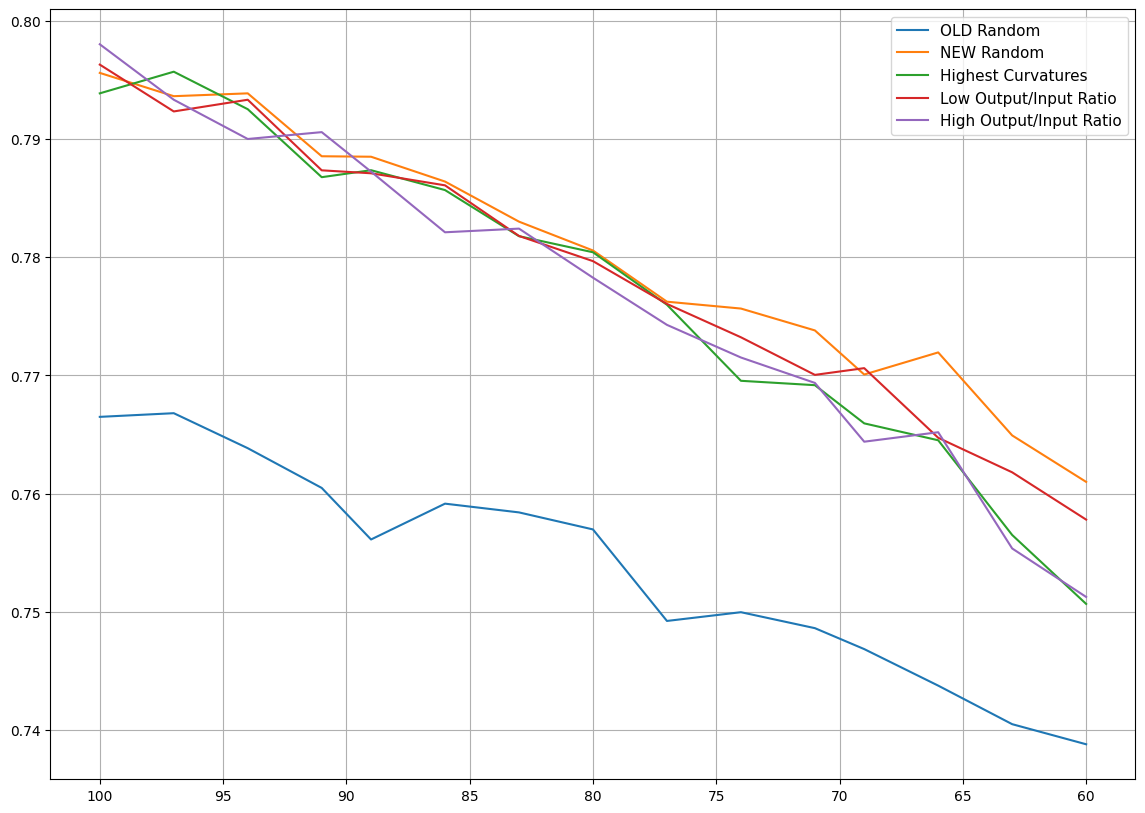

In [6]:
namelist = ['OLD Random', 'NEW Random', 'Highest Curvatures', 'Low Output/Input Ratio', 'High Output/Input Ratio']
plot_accuracies([rand, rand_2, high, ratio_low, ratio_high], namelist)

### close up on ratio tests

In [ ]:
namelist = ['Random selection', 'Low Output/Input Ratio', 'High Output/Input Ratio']
datasizes = np.logspace(3.699, 2.599, 20).astype('int')

rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random', num_models=15)
ratio_low, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_low_to_high', shuffle_seed=1337, num_models=15)
ratio_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='ratio_high_to_low', shuffle_seed=1337, num_models=15)

plot_accuracies([rand, ratio_low, ratio_high], namelist)

In [ ]:
plot_accuracies([rand, ratio_low, ratio_high], namelist)

In [ ]:
# these take a while to train, so I'm breaking them into their own cells to avoid retraining all of them if changes need to be mande to just one
rand, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='random')

In [ ]:
hess, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='hessian')

In [ ]:
keep_high, _ = get_accuracies(cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test, order_method='high_to_low', curvature_set='output')

In [ ]:
plot_accuracies([rand, hess, keep_high], ['rand', 'hess', 'keep_high'])